In [3]:
import os
import tensorflow as tf
import numpy as np


2025-12-07 20:41:09.821295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765140069.855275     447 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765140069.866636     447 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765140069.895063     447 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765140069.895089     447 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765140069.895091     447 computation_placer.cc:177] computation placer alr

In [21]:
!pip3 install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 265.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 465.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 416.7 MB/s eta 0:00:00


## Part 1: Using the Spectrogram Image to classify the Music


### Data Prepocessing

In [43]:
root_dir = "./images_original"   # 
img_size = 128
batch_size = 32


class_names = sorted([
    d for d in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, d)) and not d.startswith(".")
])
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

print("class_to_idx:", class_to_idx)
print("class_names:", class_names)

filepaths = []
labels = []

for genre in class_names:
    genre_folder = os.path.join(root_dir, genre)
    for fname in os.listdir(genre_folder):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            filepaths.append(os.path.join(genre_folder, fname))
            labels.append(class_to_idx[genre])

filepaths = np.array(filepaths)
labels = np.array(labels, dtype=np.int32)

print("Total samples:", len(filepaths))

labels = labels - labels.min()

print("unique labels:", np.unique(labels))


class_to_idx: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
class_names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Total samples: 999
unique labels: [0 1 2 3 4 5 6 7 8 9]


In [39]:
class_names, class_to_idx, filepaths, labels  
img_size = 128
batch_size = 32
import tensorflow as tf

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    img = (img - 0.5) / 0.5
    return img, label


ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

dataset_size = len(filepaths)
train_size = int(0.8 * dataset_size)
val_size   = int(0.1 * dataset_size)
test_size  = dataset_size - train_size - val_size

ds = ds.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

train_ds = ds.take(train_size)
rest_ds  = ds.skip(train_size)
val_ds   = rest_ds.take(val_size)
test_ds  = rest_ds.skip(val_size)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [45]:
for x_batch, y_batch in train_ds.take(1):
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("y_batch dtype:", y_batch.dtype)
    print("y_batch unique:", np.unique(y_batch.numpy()))


x_batch shape: (32, 128, 128, 1)
y_batch shape: (32,)
y_batch dtype: <dtype: 'int32'>
y_batch unique: [0 1 2 3 4 5 6 7 8 9]


2025-12-07 21:42:47.874389: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


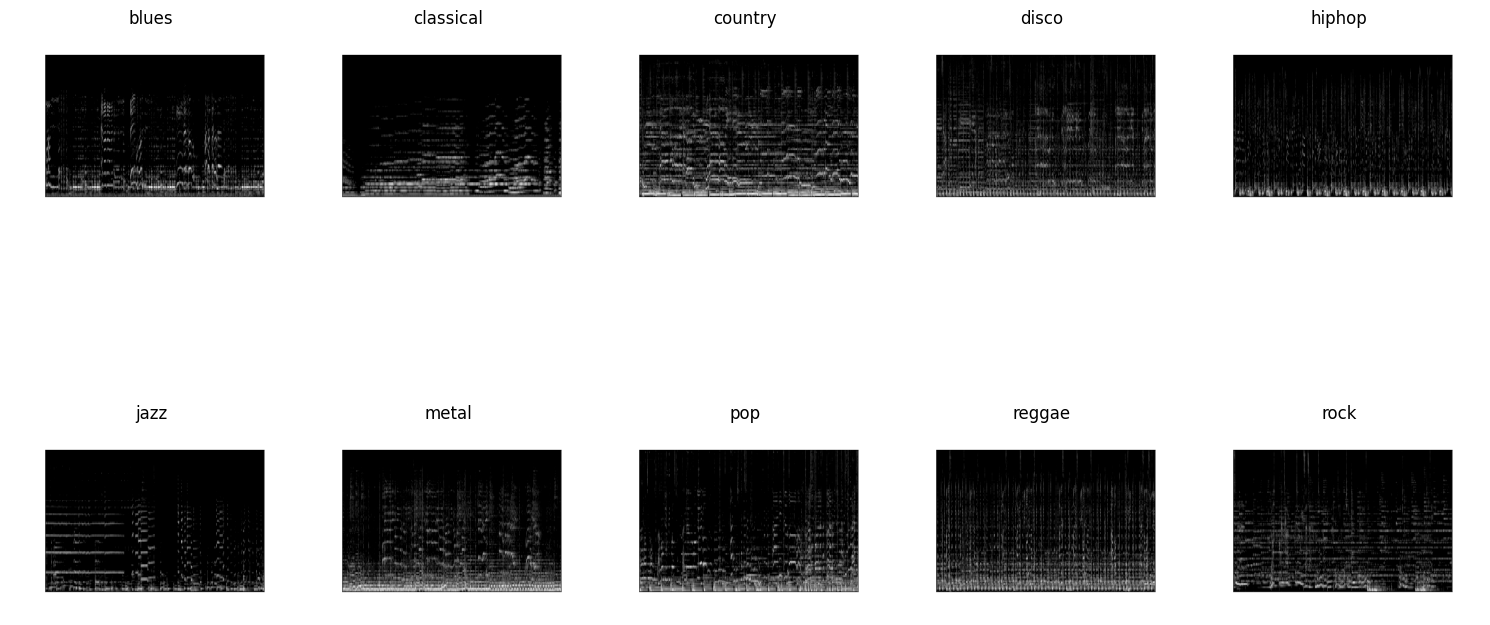

In [48]:
import matplotlib.pyplot as plt
import random
from PIL import Image


categories = class_names  

plt.figure(figsize=(15, 10))

for i, genre in enumerate(categories):
    
    genre_folder = os.path.join(root_dir, genre)
    images = [os.path.join(genre_folder, f) for f in os.listdir(genre_folder)
              if f.endswith(".png") or f.endswith(".jpg") or f.endswith(".jpeg")]
    
    img_path = random.choice(images)
    
    
    img = Image.open(img_path).convert("L")
    
    # subplot
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(genre)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [49]:

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)               
    img = tf.image.resize(img, [img_size, img_size])         
    img = tf.cast(img, tf.float32) / 255.0                   
    img = (img - 0.5) / 0.5                                  
    return img, label


ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)


dataset_size = len(filepaths)
train_size = int(0.8 * dataset_size)
val_size   = int(0.1 * dataset_size)
test_size  = dataset_size - train_size - val_size

ds = ds.shuffle(dataset_size, seed=42, reshuffle_each_iteration=False)

train_ds = ds.take(train_size)
rest_ds  = ds.skip(train_size)
val_ds   = rest_ds.take(val_size)
test_ds  = rest_ds.skip(val_size)


train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


for x_batch, y_batch in train_ds.take(1):
    print("x_batch shape:", x_batch.shape)      # (batch, 128, 128, 1)
    print("y_batch shape:", y_batch.shape)      # (batch,)
    print("y_batch unique:", np.unique(y_batch.numpy()))

x_batch shape: (32, 128, 128, 1)
y_batch shape: (32,)
y_batch unique: [0 1 2 3 4 5 6 7 8 9]


### Model Training

In [57]:
def build_mlp_spectrogram(input_shape=(128, 128, 1), num_classes=len(class_names)):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),                    
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

In [50]:
from tensorflow import keras
from tensorflow.keras import layers

def build_cnn(input_shape=(img_size, img_size, 1), num_classes=len(class_names)):
    model = keras.Sequential([
        layers.Conv2D(16, (3,3), activation="relu", padding="same", input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation="softmax")
    ])
    
    return model

model = build_cnn()
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,866 (8.09 MB)

 Trainable params: 2,121,866 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
def train_model(model, train_data, val_data, model_name, epochs=50, patience=5):
 

    # Early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    # Reduce LR on plateau
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )

    # Save best model
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=f"{model_name.replace(' ', '_')}_best.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    print(f"Training {model_name} ...")

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )

    return history, model


In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, test_data, model_name):
    """
    Evaluate trained model on the test set.

    Returns:
        Dictionary with accuracy, loss, precision, recall, F1 score
    """

    print("\n" + "="*80)
    print(f"Evaluating {model_name}")
    print("="*80)

    # Evaluate loss & accuracy
    loss, accuracy = model.evaluate(test_data, verbose=1)

    # Collect predictions
    y_true = []
    y_pred = []

    for images, labels in test_data:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Multi-class metrics
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\nResults for {model_name}:")
    print(f" Loss:     {loss:.4f}")
    print(f" Accuracy: {accuracy:.4f}")
    print(f" Precision:{precision:.4f}")
    print(f" Recall:   {recall:.4f}")
    print(f" F1 Score: {f1:.4f}")

    return {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


In [53]:
model = build_cnn()
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [54]:
history, trained_model = train_model(
    model,
    train_ds,
    val_ds,
    model_name="CNN_Spectrogram",
    epochs=30,
    patience=5
)


Training CNN_Spectrogram ...
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.0880 - loss: 2.4255
Epoch 1: val_accuracy improved from -inf to 0.05051, saving model to CNN_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.0884 - loss: 2.4228 - val_accuracy: 0.0505 - val_loss: 2.3004 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1145 - loss: 2.2941
Epoch 2: val_accuracy improved from 0.05051 to 0.16162, saving model to CNN_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.1151 - loss: 2.2936 - val_accuracy: 0.1616 - val_loss: 2.2346 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.1606 - loss: 2.2237
Epoch 3: val_accuracy did not improve from 0.16162
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.1610 - loss: 2.2224 - val_accuracy: 0.1515 - val_loss: 2.0933 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/s

In [85]:
metrics = evaluate_model(trained_model, test_ds, "CNN_Spectrogram")



Evaluating CNN_Spectrogram
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5557 - loss: 1.3751

Results for CNN_Spectrogram:
 Loss:     1.2909
 Accuracy: 0.5743
 Precision:0.5533
 Recall:   0.5394
 F1 Score: 0.5409


Exception ignored in: <function ResourceTracker.__del__ at 0x77f96fc90f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x70b459394f40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/local/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x798eb5484f40>
Traceback (most recent call last):
  File "/usr

In [59]:

mlp_model = build_mlp_spectrogram()
mlp_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

history_mlp, mlp_trained = train_model(
    mlp_model,
    train_ds,
    val_ds,
    model_name="MLP_Spectrogram",
    epochs=30,
    patience=5
)

Training MLP_Spectrogram ...
Epoch 1/30
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0956 - loss: 12.0923
Epoch 1: val_accuracy improved from -inf to 0.12121, saving model to MLP_Spectrogram_best.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.0945 - loss: 11.5881 - val_accuracy: 0.1212 - val_loss: 2.3040 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0770 - loss: 2.3313
Epoch 2: val_accuracy did not improve from 0.12121
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.0777 - loss: 2.3321 - val_accuracy: 0.0606 - val_loss: 2.3043 - learning_rate: 0.0010
Epoch 3/30
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0778 - loss: 2.3995
Epoch 3: val_accuracy did not improve from 0.12121
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0803 - loss: 2.3943 - val_accuracy: 0.0606 - val_loss: 2.3048 - learning_rate: 0.0010
Epoch 4/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0891 - loss: 2.3543
Epoch 4: Re

## Part 2: Using feature data of the music (feature_3_sec.csv) to classify the music

### Data Prepocessing

In [62]:
import pandas as pd

df = pd.read_csv("features_3_sec.csv")   # or features_30_sec.csv
print(df.shape)
df.head()


(9990, 60)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [64]:
# labeling
labels = df["label"].values
label_to_idx = {name: i for i, name in enumerate(sorted(df["label"].unique()))}
idx_to_label = {v: k for k, v in label_to_idx.items()}
y = df["label"].map(label_to_idx).values
df["label_idx"] = y
print(label_to_idx)


{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [65]:
drop_cols = ["filename", "label"]
X = df.drop(columns=drop_cols).values   # shape: (N, 58 或 60)
y = df["label_idx"].values

In [67]:
!pip3 install seaborn

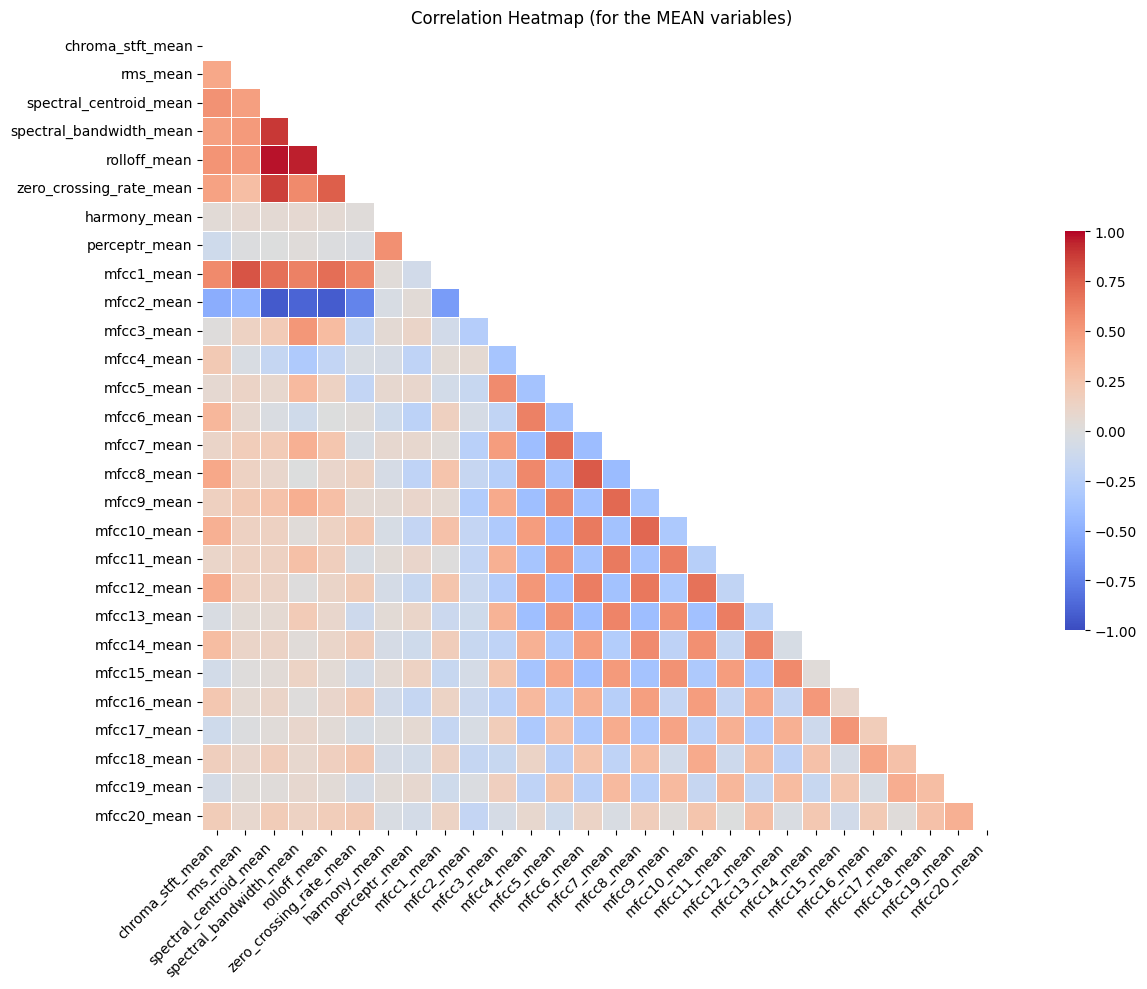

In [73]:

import seaborn as sns


mean_cols = [col for col in df.columns 
             if "mean" in col and col not in ["filename", "label"]]

df_means = df[mean_cols]

corr = df_means.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))   

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    mask=mask,          
    cmap="coolwarm",    
    vmin=-1, vmax=1,   
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .5}
)
plt.title("Correlation Heatmap (for the MEAN variables)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [74]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

Train: (7992, 58) Val: (999, 58) Test: (999, 58)


### Model training

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# define the neighbors
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21],
    "weights": ["uniform", "distance"],
    "metric": ["minkowski", "manhattan", "cosine"],
    "p": [1, 2]  # only used for minkowski
}

# build the model
knn = KNeighborsClassifier()

# GridSearchCV
grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,                  # 5-fold cross validation
    scoring="accuracy",
    n_jobs=-1,             
    verbose=1
)

grid.fit(X_train_scaled, y_train)

# best parameter
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best CV Accuracy: 0.9191697564419565


In [81]:
best_knn = grid.best_estimator_

# testing
test_acc = best_knn.score(X_test_scaled, y_test)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.9259259259259259


In [80]:
from sklearn.metrics import classification_report

y_pred = best_knn.predict(X_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.91      0.91       100
           1       0.92      0.96      0.94       100
           2       0.89      0.87      0.88        99
           3       0.89      0.93      0.91       100
           4       0.96      0.95      0.95       100
           5       0.90      0.90      0.90       100
           6       0.98      0.98      0.98       100
           7       0.97      0.90      0.93       100
           8       0.91      0.96      0.94       100
           9       0.93      0.90      0.91       100

    accuracy                           0.93       999
   macro avg       0.93      0.93      0.93       999
weighted avg       0.93      0.93      0.93       999



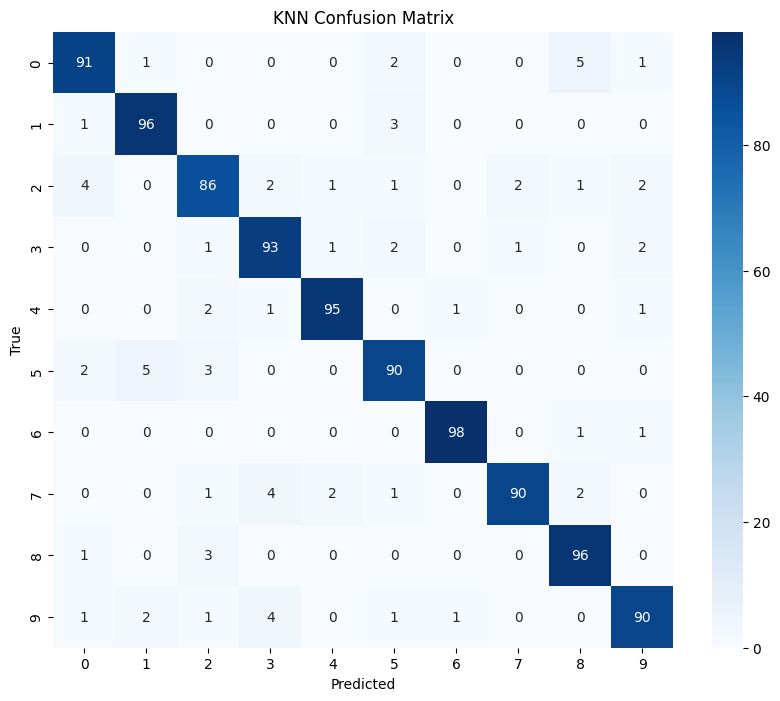

In [84]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("KNN Confusion Matrix")
plt.show()


In [89]:
import tensorflow as tf
from tensorflow import keras as k


input_dim = X_train_scaled.shape[1]


num_classes = y_train.nunique()   

def build_mlp(input_dim, num_classes):
    model = k.models.Sequential([
        k.layers.Input(shape=(input_dim,)),
        k.layers.Dense(256, activation='relu'),
        k.layers.Dropout(0.4),
        k.layers.Dense(128, activation='relu'),
        k.layers.Dropout(0.3),
        k.layers.Dense(64, activation='relu'),
        k.layers.Dense(num_classes, activation='softmax')
    ])
    return model

model_mlp = build_mlp(input_dim, num_classes)
model_mlp.summary()

model_mlp.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

callbacks = [
    k.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    )
]

history_mlp = model_mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=80,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 256)            │        15,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,906 (222.29 KB)

 Trainable params: 56,906 (222.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3209 - loss: 1.8846 - val_accuracy: 0.6206 - val_loss: 1.1005
Epoch 2/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5768 - loss: 1.1855 - val_accuracy: 0.6877 - val_loss: 0.9065
Epoch 3/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6450 - loss: 0.9935 - val_accuracy: 0.7077 - val_loss: 0.8204
Epoch 4/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6850 - loss: 0.9067 - val_accuracy: 0.7427 - val_loss: 0.7416
Epoch 5/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7161 - loss: 0.8134 - val_accuracy: 0.7528 - val_loss: 0.6876
Epoch 6/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7317 - loss: 0.7658 - val_accuracy: 0.7688 - val_loss: 0.6536
Epoch 7/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7451 - loss: 0.7258 - val_accuracy: 0.7858 - val_loss: 0.6160
Epoch 8/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7590 - loss: 0.6987 - val_accuracy: 0.

MLP Test Accuracy: 0.9029029011726379
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

MLP Classification Report (Test):
               precision    recall  f1-score   support

           0       0.96      0.91      0.93       100
           1       0.94      0.95      0.95       100
           2       0.85      0.89      0.87        99
           3       0.88      0.81      0.84       100
           4       0.94      0.87      0.90       100
           5       0.88      0.95      0.91       100
           6       0.95      0.97      0.96       100
           7       0.90      0.91      0.91       100
           8       0.85      0.94      0.90       100
           9       0.88      0.83      0.86       100

    accuracy                           0.90       999
   macro avg       0.90      0.90      0.90       999
weighted avg       0.90      0.90      0.90       999



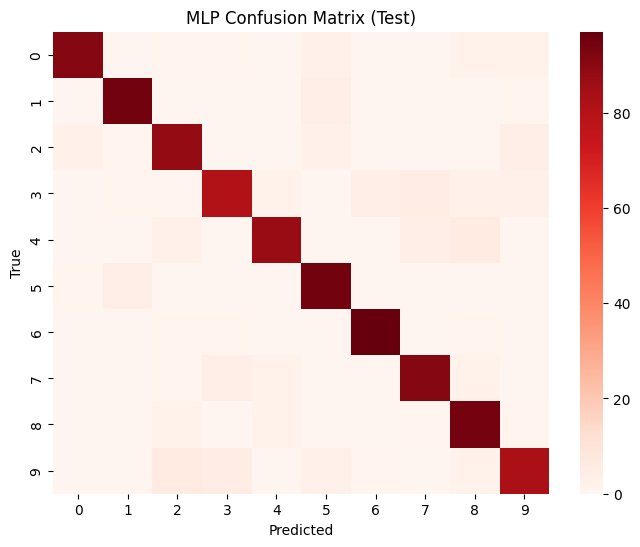

In [90]:
test_loss, test_acc = model_mlp.evaluate(X_test_scaled, y_test, verbose=0)
print("MLP Test Accuracy:", test_acc)

y_test_pred_mlp = model_mlp.predict(X_test_scaled).argmax(axis=1)
print("\nMLP Classification Report (Test):\n",
      classification_report(y_test, y_test_pred_mlp))

cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, cmap="Reds", annot=False)
plt.title("MLP Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
